In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
sys.path.append(r'/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/')
from FFT_get import fftget
from IFFT_get import ifftget
from Filterparameter import filter_get
from equivalent import CEL
from galacticnoise_get import gala
from Time_domain_Shower_Edata_get import time_data_get
from LNAparameter_get import LNA_get

from scipy import signal
from scipy.fftpack import ifft,fft
from scipy.signal import hilbert

In [2]:
def compute_3by3matrix(h1,h2,h3,v):
    a1,b1,c1=h1
    a2, b2, c2 = h2
    a3, b3, c3 = h3
    d1,d2,d3=v
    det=a1 * b2* c3 - a1 *b3 *c2 - a2* b1* c3 + a2* b3 *c1 + a3 *b1 *c2 - a3* b2 *c1        
    x = (b1 * c2 * d3 - b1 * c3 * d2 - b2 * c1 * d3 + b2 * c3 * d1 + b3 * c1 * d2 - b3 * c2 * d1) / det
    y = (-a1 * c2 * d3 + a1 * c3 * d2 + a2 * c1 * d3 - a2 * c3 * d1 - a3 * c1 * d2 + a3 * c2 * d1) / det
    z = (a1 * b2 * d3 - a1 * b3 * d2 - a2 * b1 * d3 + a2 * b3 * d1 + a3 * b1 * d2 - a3 * b2 * d1) / det
    E=np.zeros((len(x), 3), dtype=complex)
    E[:,0]=x;E[:,1]=y;E[:,2]=z
    return E

def rotation_m(theta,phi):
    return np.array([[np.cos(theta)*np.cos(phi),-np.sin(phi),np.sin(theta)*np.cos(phi)],
                     [np.cos(theta)*np.sin(phi),np.cos(phi),np.sin(theta)*np.sin(phi)],
                     [-np.sin(theta),0,np.cos(theta)]])



In [18]:
E_path='/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/test/Stshp_MZS_QGS204JET_Proton_0.21_56.7_90.0_5/Stshp_MZS_QGS204JET_Proton_0.21_56.7_90.0_5_trace/a20.trace'
E_path='/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/test/Stshp_MZS_QGS204JET_Proton_3.98_56.7_45.0_8/Stshp_MZS_QGS204JET_Proton_3.98_56.7_45.0_8/a15.trace'
Ts = 0.5
e_theta =56.7#.9#79.6#56.7
e_phi = 45#315#90.0
show_flag=0
[t_cut, ex_cut, ey_cut, ez_cut, fs, f0, f, f1, N] = time_data_get(E_path, Ts, 0)
#t_cut, ex_cut, ey_cut, ez_cut=np.loadtxt('/Users/zhangkewen/Desktop/3.98EeV_79.6_315.0_nonoise_Efield_trace_t.txt').T
#t_cut, ex_cut, ey_cut, ez_cut,vx_cut, vy_cut, vz_cut=np.loadtxt('/Users/zhangkewen/Desktop/vfilter_a13_trace.txt').T
Edata = ex_cut
Edata = np.column_stack((Edata, ey_cut))
Edata = np.column_stack((Edata, ez_cut))
#response parameters
[cable_coefficient, filter_coefficient] = filter_get(2000, f0, 1, 0)
[Lce_complex, antennas11_complex_short] = CEL(e_theta, e_phi, N, f0, 1, 0)
[rou1_complex, rou2_complex, rou3_complex] = LNA_get(antennas11_complex_short, N, f0, 1, 0)


In [19]:
Lce_sphere=np.zeros(np.shape(Lce_complex),dtype='complex')
Lce_sphere1=np.zeros(np.shape(Lce_complex),dtype='complex')
#R_cart2sph=coord_matrix(e_theta*np.pi/180,e_phi*np.pi/180)
R_sph2cart=rotation_m(e_theta*np.pi/180,e_phi*np.pi/180)
R_cart2sph=np.linalg.inv(np.matrix(R_sph2cart))

for i in range(2000):
    for j in range(3):
        Lce_sphere[i,j,:]=np.dot(R_cart2sph,Lce_complex[i,j, :])



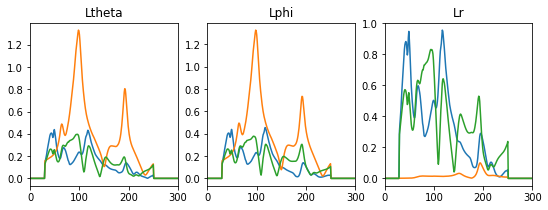

In [20]:
Lce_sphere=np.zeros(np.shape(Lce_complex),dtype='complex')
R_sph2cart=rotation_m(e_theta*np.pi/180,e_phi*np.pi/180)
R_cart2sph=np.linalg.inv(np.matrix(R_sph2cart))
#vector in order of(theta,phi,r)
string_sphere = np.array(['theta', 'phi', 'r'])
for i in range(2000):
    for j in range(3):
        Lce_sphere[i,j,:]=np.dot(R_cart2sph,Lce_complex[i,j, :])
        
plt.figure(figsize=(9, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    for j in range(3):
        plt.plot(f, abs(Lce_sphere[:, i, j]))
        plt.title('L'+string_sphere[i])
        plt.xlim(0, 300)    

In [21]:
Edata_sph=np.zeros(np.shape(Edata))
Edata_sph1=np.zeros(np.shape(Edata))
Edata_sph2cart=np.zeros(np.shape(Edata))
R_rot = rotation_m(e_theta * np.pi / 180, e_phi * np.pi / 180)
R_inv = np.linalg.inv(np.matrix(R_rot))
for j in range(2000):
    Edata_sph[j, :]=np.dot(R_cart2sph,Edata[j, :])
    Edata_sph2cart[j, :]=np.dot(R_rot,Edata_sph[j, :])
    #vector_E = np.array([[Edata[:, 0][j]], [Edata[:, 1][j]], [Edata[:, 2][j]]])
    #et_E, ep_E, er_E = R_inv * vector_E
    #Edata_sph1[:, 0][j] = et_E.A[0][0];Edata_sph1[:, 1][j] = ep_E.A[0][0];Edata_sph1[:, 2][j] = er_E.A[0][0]

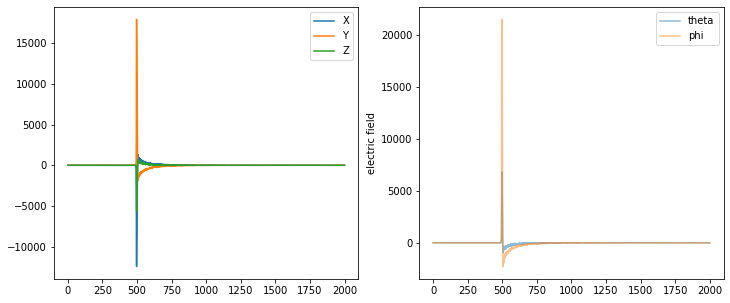

In [23]:
string = np.array(['X', 'Y', 'Z'])
string_sphere = np.array(['theta', 'phi', 'r'])
plt.figure(figsize=(12, 5))
plt.subplot(1,2,2)
for i in range(2):
    plt.plot(Edata_sph[:,i],label=string_sphere[i],alpha=0.5)
plt.legend()
plt.ylabel('electric field')
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(Edata[:,i],label=string[i])
plt.legend()

In [153]:
Lcehang = Lce_complex.shape[0]
Lcelie = Lce_complex.shape[2]
Voc_shower_complex = np.zeros((Lcehang, Lcelie), dtype=complex)
Voc_shower_sph_complex = np.zeros((Lcehang, Lcelie), dtype=complex)
E_shower_sph_fft,_,_=fftget(Edata_sph, N, f1,0)
E_shower_fft,_,_= fftget(Edata, N, f1,0)
for p in range(3):
    Voc_shower_complex[:, p] =Lce_complex[:, 0, p] * E_shower_fft[:, 0] + Lce_complex[:, 1, p] * E_shower_fft[:,1] + Lce_complex[:, 2,p] * E_shower_fft[:,2] + 0
    Voc_shower_sph_complex[:, p] =Lce_sphere[:, 0, p] * E_shower_sph_fft[:, 0] + Lce_sphere[:, 1, p] * E_shower_sph_fft[:,1] + Lce_sphere[:, 2,p] * E_shower_sph_fft[:,2] + 0
    #Voc_shower_sph_complex[:, p] =Lce_sphere[:, p, 0] * E_shower_sph_fft[:, 0] + Lce_sphere[:, p, 1] * E_shower_sph_fft[:,1] + Lce_sphere[:, p,2] * E_shower_sph_fft[:,2] + 0


    
Voc_shower_t,_,_=ifftget(Voc_shower_complex,N,f1,2)
Voc_sph_shower_t,_,_=ifftget(Voc_shower_sph_complex,N,f1,2)


In [154]:
V_car2sph_voc = np.zeros((Lcehang, Lcelie))
V_sph2car_voc = np.zeros((Lcehang, Lcelie))
#R_sph2cart=rotation_m(e_theta*np.pi/180,e_phi*np.pi/180)
#R_cart2sph=np.linalg.inv(np.matrix(R_sph2cart))
for i in range(2000):
    V_car2sph_voc[i,:]=np.dot(R_cart2sph,Voc_shower_t[i,:])
    V_sph2car_voc[i,:]=np.dot(R_sph2cart,Voc_sph_shower_t[i,:])
    #vt,vp,vr=np.linalg.inv(np.matrix(coord_matrix(e_theta*np.pi/180,e_phi*np.pi/180)))*vector_voc
    #V_car2sph_voc[:, 0][i] = vt.A[0][0];V_car2sph_voc[:, 1][i] = vp.A[0][0];V_car2sph_voc[:, 2][i] = vr.A[0][0]

Text(0.5, 1.0, 'cartitian to spherical')

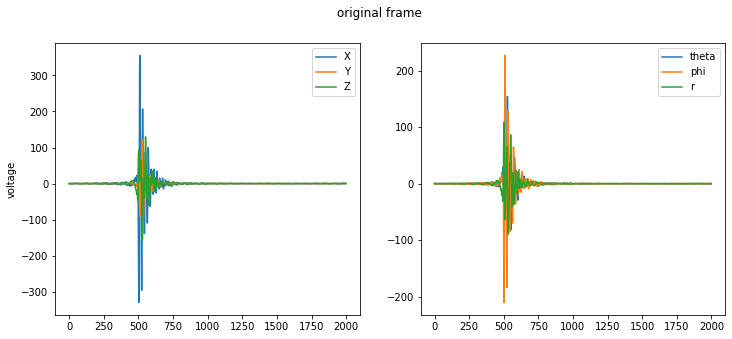

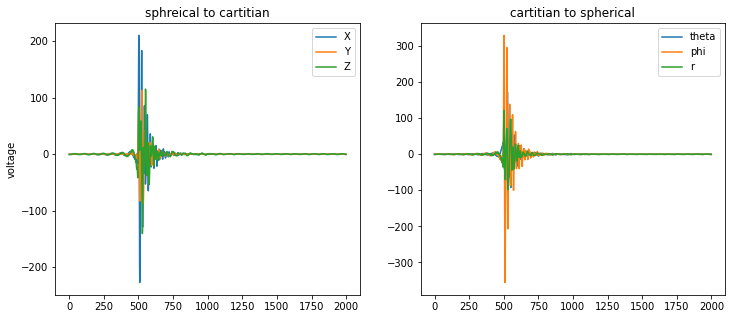

In [155]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(Voc_shower_t[:,i],label=string[i])
plt.legend()
plt.ylabel('voltage')
plt.subplot(1,2,2)
for i in range(3):
    plt.plot(Voc_sph_shower_t[:,i],label=string_sphere[i])
plt.legend()
plt.suptitle('original frame')
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(V_sph2car_voc[:,i],label=string[i])
plt.legend()
plt.title('sphreical to cartitian')
plt.ylabel('voltage')
plt.subplot(1,2,2)
for i in range(3):
    plt.plot(V_car2sph_voc[:,i],label=string_sphere[i])
plt.legend()
plt.title('cartitian to spherical')

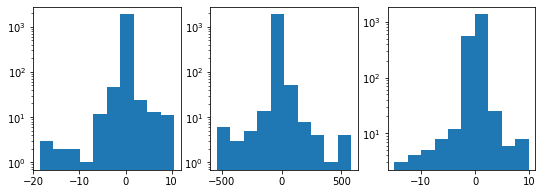

In [143]:
plt.figure(figsize=(9, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(Voc_sph_shower_t[:,i]-V_car2sph_voc[:,i],log=1)


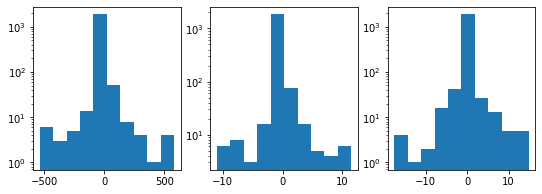

In [144]:
plt.figure(figsize=(9, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(Voc_shower_t[:,i]-V_sph2car_voc[:,i],log=1)

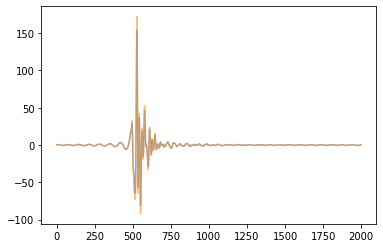

In [145]:
plt.plot(Voc_sph_shower_t[:,0],alpha=0.5)
plt.plot(V_car2sph_voc[:,0],alpha=0.5)

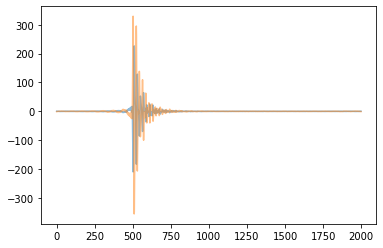

In [146]:
plt.plot(Voc_sph_shower_t[:,1],alpha=0.5)
plt.plot(V_car2sph_voc[:,1],alpha=0.5)

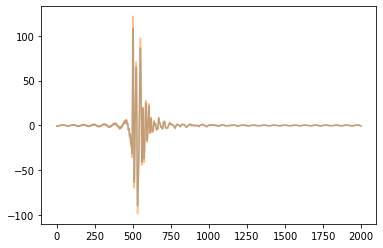

In [147]:
plt.plot(Voc_sph_shower_t[:,2],alpha=0.5)
plt.plot(V_car2sph_voc[:,2],alpha=0.5)